In [61]:
import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [62]:
print("Num GPUs Available: ", tf.config.list_physical_devices())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [63]:
df = pd.read_csv('data/data_by_station/C6.zip', compression='zip', header=0, sep=',')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df = df.astype({'T': 'float', 'HR': 'float', 'P': 'float', 'u2': 'float', 'v2': 'float', 'u6': 'float', 'v6': 'float', 'u10': 'float', 'v10': 'float', 'altitud': 'float', 'latitud': 'float', 'longitud': 'float'})

In [64]:
df.head()

,T,HR,P,station,date,u2,v2,u6,v6,u10,v10,altitud,latitud,longitud
0,7.7,71.0,966.0,C6,2010-01-01 00:00:00,-1.0,-1.0,-1.0,-1.0,5.9,4.7,264.0,41.6566,0.95172
1,7.3,71.0,966.0,C6,2010-01-01 00:30:00,-1.0,-1.0,-1.0,-1.0,4.3,6.1,264.0,41.6566,0.95172
2,6.7,69.0,967.0,C6,2010-01-01 01:00:00,-1.0,-1.0,-1.0,-1.0,4.0,-6.8,264.0,41.6566,0.95172
3,6.1,71.0,967.0,C6,2010-01-01 01:30:00,-1.0,-1.0,-1.0,-1.0,7.8,-0.3,264.0,41.6566,0.95172
4,5.8,71.0,968.0,C6,2010-01-01 02:00:00,-1.0,-1.0,-1.0,-1.0,-8.1,-0.8,264.0,41.6566,0.95172


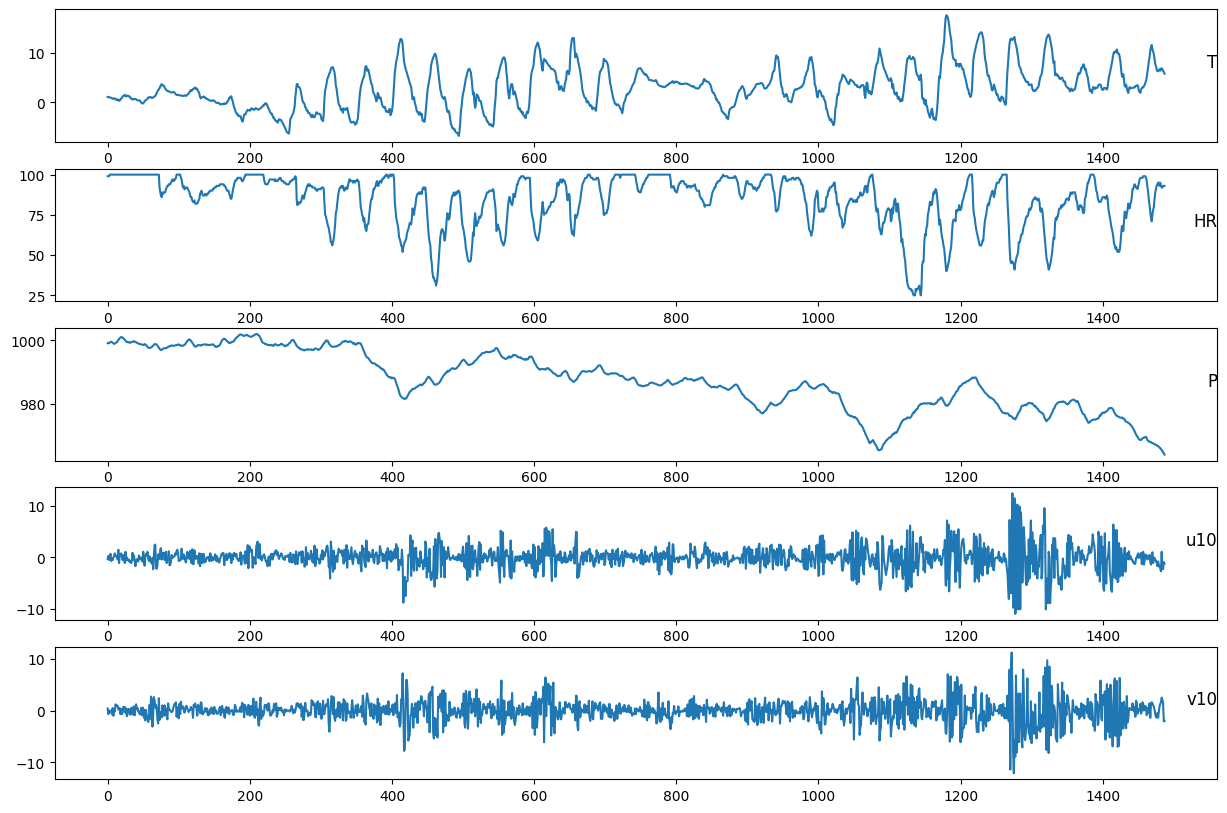

In [65]:
copy_df = df.copy()
copy_df.set_index('date', inplace=True)
copy_df = copy_df[(copy_df.index.year == 2019) & (copy_df.index.month == 1)]
groups = [0, 1, 2, 8, 9]
i = 1
values = copy_df.values
plt.figure(figsize=(15, 10))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(copy_df.columns[group], y=0.5, loc='right')
 i += 1
plt.show()
del copy_df, groups, i, values

In [66]:
df['day'] = df['date'].dt.dayofyear
df['time'] = df['date'].dt.hour * 60 + df['date'].dt.minute

cols = ['T', 'HR', 'P', 'u10', 'v10', 'day', 'time']
min_maxs = {}

for col in cols:
    min_maxs[col] = {'min': df[col].min(), 'max': df[col].max()}
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df = df[['T', 'HR', 'P', 'u10', 'v10', 'day', 'time', 'date']]

In [67]:
df.head()

,T,HR,P,u10,v10,day,time,date
0,0.331349,0.684783,0.252033,0.705882,0.661922,0.0,0.000000,2010-01-01 00:00:00
1,0.323413,0.684783,0.252033,0.650519,0.711744,0.0,0.021277,2010-01-01 00:30:00
2,0.311508,0.663043,0.268293,0.640138,0.252669,0.0,0.042553,2010-01-01 01:00:00
3,0.299603,0.684783,0.268293,0.771626,0.483986,0.0,0.063830,2010-01-01 01:30:00
4,0.293651,0.684783,0.284553,0.221453,0.466192,0.0,0.085106,2010-01-01 02:00:00


In [68]:
min_maxs

{'T': {'min': -9.0, 'max': 41.4},
 'HR': {'min': 8.0, 'max': 100.0},
 'P': {'min': 950.5, 'max': 1012.0},
 'u10': {'min': -14.5, 'max': 14.4},
 'v10': {'min': -13.9, 'max': 14.2},
 'day': {'min': 1, 'max': 366},
 'time': {'min': 0, 'max': 1410}}

# LSTM

In [69]:
input_width = 96
prediction_width = 1

df_train = df[df['date'] < '2019-01-01']
df_test = df[df['date'] >= '2019-01-01']

train_X = []
train_Y = []

for i in range(input_width, len(df_train) - prediction_width + 1):
    train_X.append(df_train.iloc[i - input_width:i][cols].values)
    train_Y.append(df_train.iloc[i:i + prediction_width][['T', 'u10', 'v10']].values)

test_X = []
test_Y = []

for i in range(input_width, len(df_test) - prediction_width + 1):
    test_X.append(df_test.iloc[i - input_width:i][cols].values)
    test_Y.append(df_test.iloc[i:i + prediction_width][['T', 'u10', 'v10']].values)

train_X = np.array(train_X)
train_Y = np.array(train_Y)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

test_Y[:, 0, 0] = test_Y[:, 0, 0] * (min_maxs['T']['max'] - min_maxs['T']['min']) + min_maxs['T']['min']
test_Y[:, 0, 1] = test_Y[:, 0, 1] * (min_maxs['u10']['max'] - min_maxs['u10']['min']) + min_maxs['u10']['min']
test_Y[:, 0, 2] = test_Y[:, 0, 2] * (min_maxs['v10']['max'] - min_maxs['v10']['min']) + min_maxs['v10']['min']

In [77]:
model = Sequential()
model.add(LSTM(32, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                5120      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 5,219
Trainable params: 5,219
Non-trainable params: 0
_________________________________________________________________


In [78]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_X, train_Y, epochs=15, batch_size=32, validation_split=0.1, verbose=1, shuffle=False)

Epoch 1/15
4435/4435 [==============================] - 50s 11ms/step - loss: 0.0102 - mae: 0.0769 - val_loss: 0.0237 - val_mae: 0.1069
Epoch 2/15
4435/4435 [==============================] - 45s 10ms/step - loss: 0.0080 - mae: 0.0684 - val_loss: 0.0229 - val_mae: 0.1063
Epoch 3/15
4435/4435 [==============================] - 45s 10ms/step - loss: 0.0079 - mae: 0.0681 - val_loss: 0.0213 - val_mae: 0.1035
Epoch 4/15
4435/4435 [==============================] - 45s 10ms/step - loss: 0.0079 - mae: 0.0679 - val_loss: 0.0195 - val_mae: 0.0998
Epoch 5/15
4435/4435 [==============================] - 45s 10ms/step - loss: 0.0077 - mae: 0.0672 - val_loss: 0.0107 - val_mae: 0.0765
Epoch 6/15
4435/4435 [==============================] - 45s 10ms/step - loss: 0.0074 - mae: 0.0660 - val_loss: 0.0076 - val_mae: 0.0657
Epoch 7/15
4435/4435 [==============================] - 45s 10ms/step - loss: 0.0073 - mae: 0.0657 - val_loss: 0.0070 - val_mae: 0.0635
Epoch 8/15
4435/4435 [==========================

In [79]:
model.save('models/lstm_16_15epochs_32bs.h5')

545/545 [==============================] - 3s 4ms/step


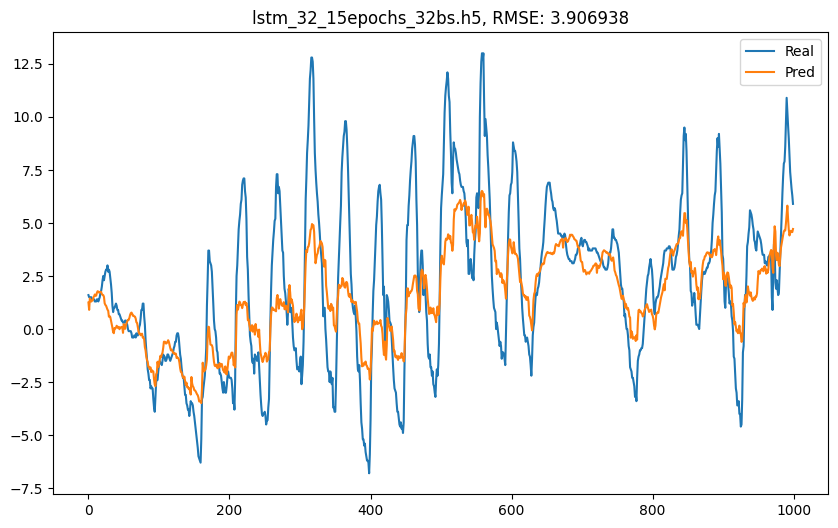

545/545 [==============================] - 4s 7ms/step


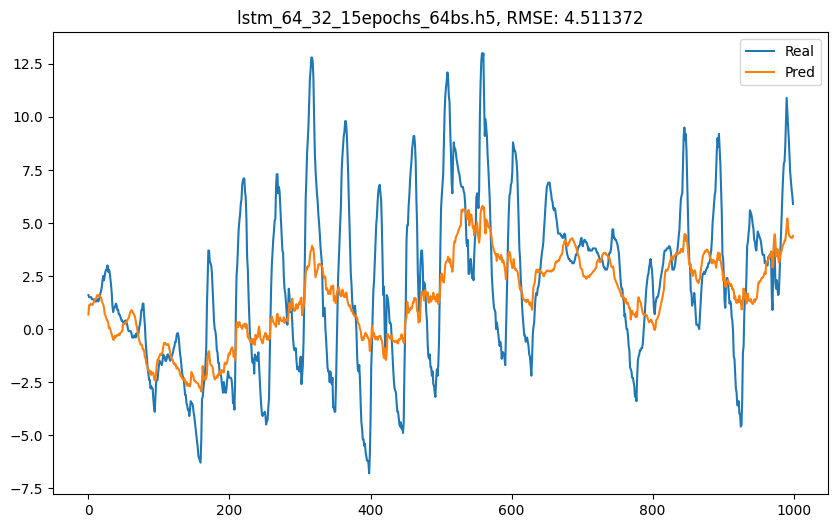

545/545 [==============================] - 2s 4ms/step


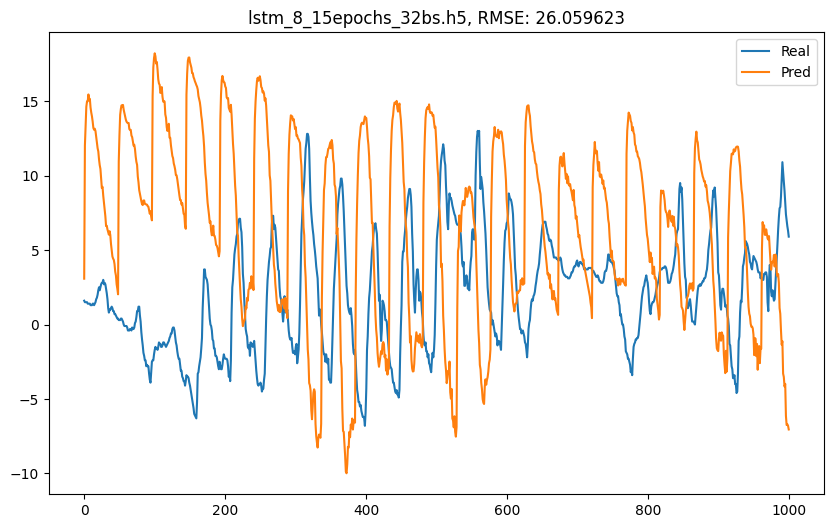

545/545 [==============================] - 4s 6ms/step


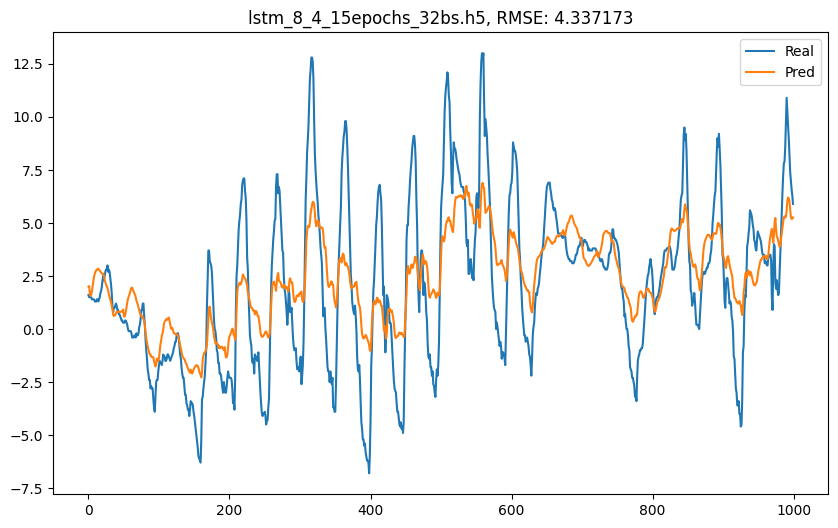

In [80]:
for model in os.listdir('models'):
    model_loaded = keras.models.load_model(f'models/{model}')

    y_pred = model_loaded.predict(test_X)

    plt.figure(figsize=(10, 6))
    y_pred[:, 0] = y_pred[:, 0] * (min_maxs['T']['max'] - min_maxs['T']['min']) + min_maxs['T']['min']
    
    plt.plot(test_Y[:1000, 0, 0], label='Real')
    plt.plot(y_pred[:1000, 0], label='Pred')
    
    rmse = np.sqrt(np.mean(np.power((test_Y[:, 0, 0] - y_pred[:, 0]), 2)))
    plt.legend()
    plt.title(f'{model}, RMSE: {rmse:.6f}')
    plt.show()


545/545 [==============================] - 2s 4ms/step


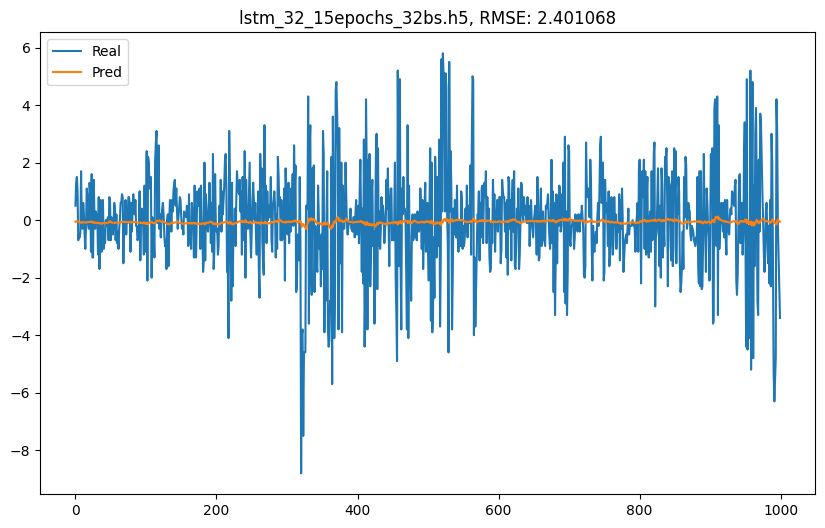

545/545 [==============================] - 4s 6ms/step


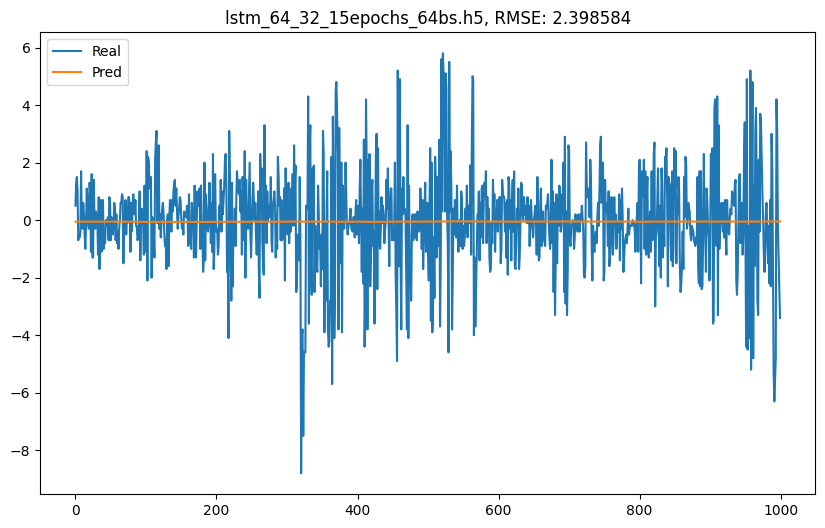

545/545 [==============================] - 2s 4ms/step


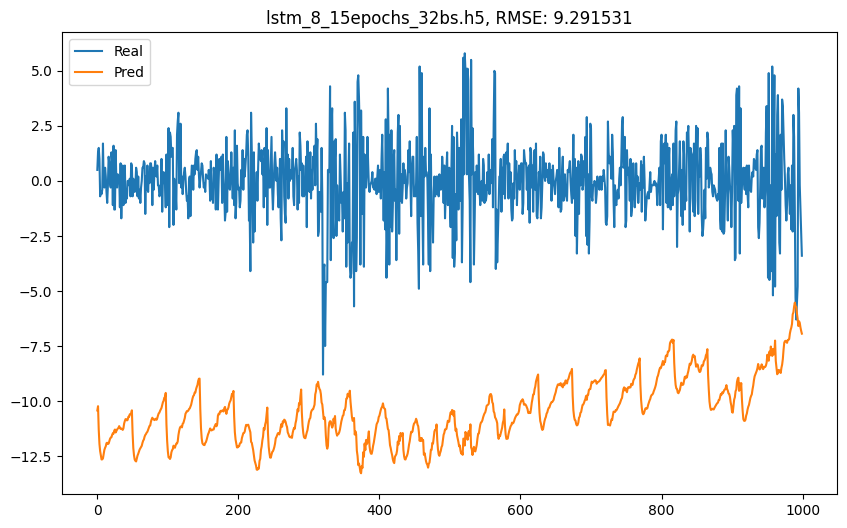

545/545 [==============================] - 4s 6ms/step


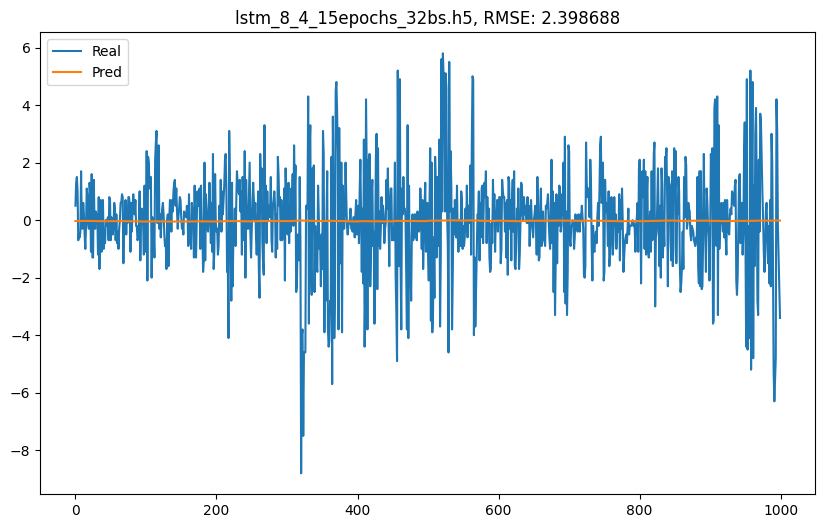

In [81]:
for model in os.listdir('models'):
    model_loaded = keras.models.load_model(f'models/{model}')

    y_pred = model_loaded.predict(test_X)

    plt.figure(figsize=(10, 6))
    y_pred[:, 1] = y_pred[:, 1] * (min_maxs['u10']['max'] - min_maxs['u10']['min']) + min_maxs['u10']['min']
    
    plt.plot(test_Y[:1000, 0, 1], label='Real')
    plt.plot(y_pred[:1000, 1], label='Pred')
    
    rmse = np.sqrt(np.mean(np.power((test_Y[:, 0, 1] - y_pred[:, 1]), 2)))
    plt.legend()
    plt.title(f'{model}, RMSE: {rmse:.6f}')
    plt.show()

545/545 [==============================] - 3s 4ms/step


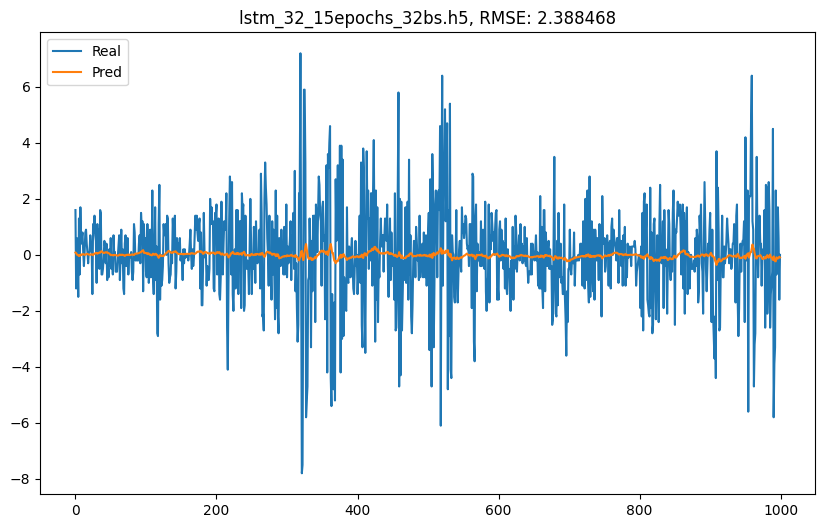

545/545 [==============================] - 4s 7ms/step


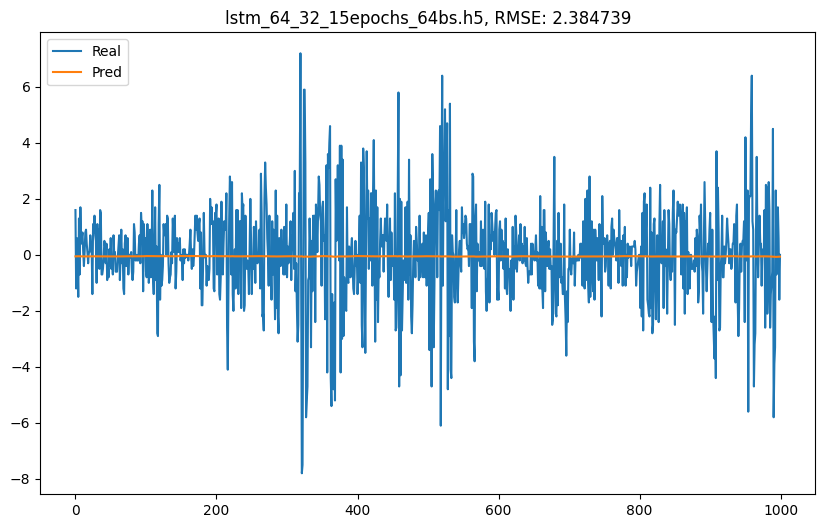

545/545 [==============================] - 2s 4ms/step


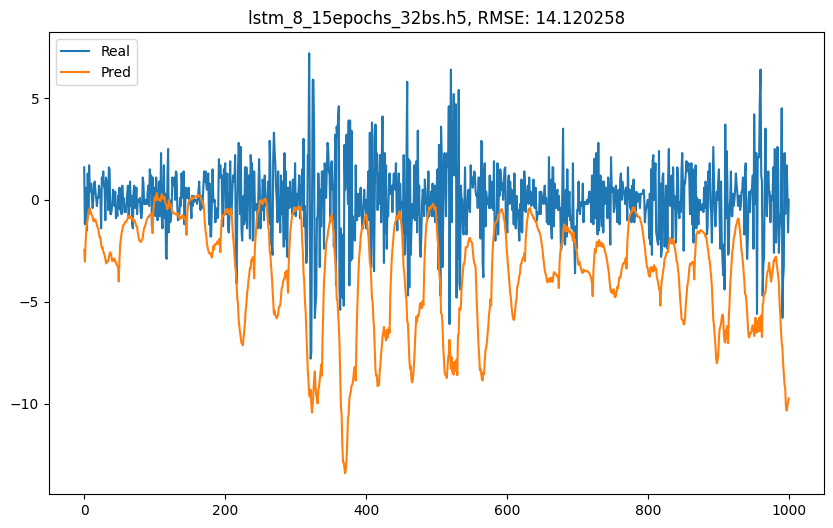

545/545 [==============================] - 4s 6ms/step


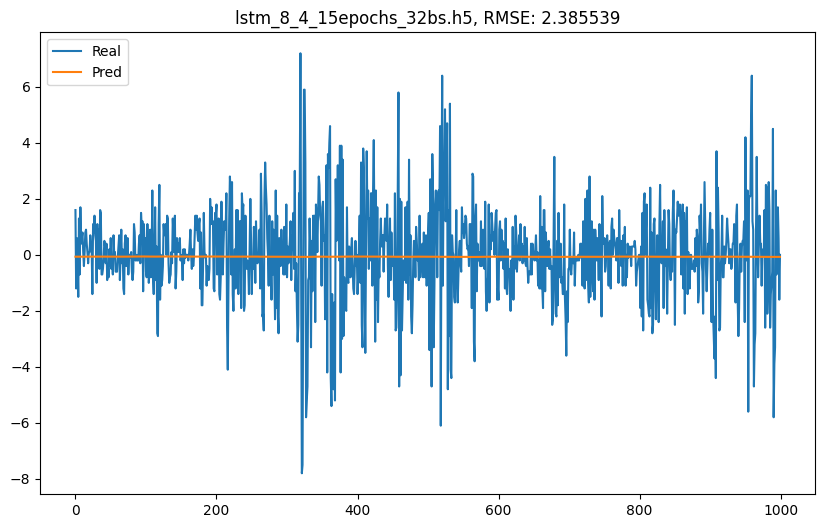

In [82]:
for model in os.listdir('models'):
    model_loaded = keras.models.load_model(f'models/{model}')

    y_pred = model_loaded.predict(test_X)

    plt.figure(figsize=(10, 6))
    y_pred[:, 2] = y_pred[:, 2] * (min_maxs['v10']['max'] - min_maxs['v10']['min']) + min_maxs['v10']['min']
    
    plt.plot(test_Y[:1000, 0, 2], label='Real')
    plt.plot(y_pred[:1000, 2], label='Pred')
    
    rmse = np.sqrt(np.mean(np.power((test_Y[:, 0, 2] - y_pred[:, 2]), 2)))
    plt.legend()
    plt.title(f'{model}, RMSE: {rmse:.6f}')
    plt.show()